In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analytic_solution import oscillator    
from IPython.display import display,Markdown
import matplotlib
matplotlib.rc('text', usetex = True)

### Training for 10,0000 EPOCHS
#### k = 20.
#### m = 1.
#### collocation_points = 256
#### t $\in$ [0,3]
$$H(p,q) = \frac{p^2}{2m} + \frac{1}{2} kq^2$$

Consider $\hat{p}$ and $\hat{q}$ to be outputs from the neural network and $\hat{H} = H(\hat{p},\hat{q})$
#### PINN
$$\mathcal{L}_{PINN} = \mathcal{L}_{boundary} + \frac{1}{N} \sum_{i=1}^N |f(t_i)|^2$$ 
#### PINN without Hamiltonian residual
$$\mathcal{L}_{PINN-geo} = \mathcal{L}_{boundary} + \frac{1}{N} \sum_{i=1}^N |f(t_i)|^2 + \frac{1}{N} \sum_{i=1}^N \left|\frac{(H-H_0)}{H_0}\right|^2$$
#### PINN with Hamiltonian residual
$$\mathcal{L}_{PINN-geo-hamiltonian-residual} = \mathcal{L}_{boundary} 
+ \frac{1}{N} \sum_{i=1}^N |\frac{\partial{\hat{H}}}{\partial{\hat{q}}} - \frac{d\hat{p}}{dt}|^2  
+ \frac{1}{N} \sum_{i=1}^N |\frac{\partial{\hat{H}}}{\partial{\hat{p}}} +\frac{d\hat{q}}{dt}|^2  
+ \frac{1}{N} \sum_{i=1}^N \left|\frac{(\hat{H}-H_0)}{H_0}\right|^2$$

Activation function: tanh

Optimizer: Adam

Learning rate: 0.001

Activation function: SIREN - sin(x) as activation function, with the weights constrained to be in the range $[-6/\sqrt(d_{in}), 6/\sqrt(d_{in})]$ where $d_{in}$ is the number of input units.

In [32]:
figsize = (20,10)
fontsize = 22

In [33]:
x0 = tf.convert_to_tensor(1.0,dtype=tf.float64)
x_0 = tf.convert_to_tensor(0.0,dtype=tf.float64)
k = tf.constant(20.0,dtype=tf.float64)
m = tf.constant(1.0,dtype=tf.float64)

l = tf.constant(0.0,dtype=tf.float64)
u = tf.constant(3.0,dtype=tf.float64)
f = 256
t = tf.reshape(tf.linspace(l,u,1000),[-1,1])
p = tf.reshape(tf.ones_like(t)*x_0,[-1,1])
q = tf.reshape(tf.ones_like(t)*x0,[-1,1])
inp = tf.concat([t,p,q],axis=1)


In [34]:
def model_prediction(model,inp):
    return tf.reshape(model(inp)[:,-1],[-1,1])

In [35]:
def energy_prediction(model,inp):
    p = tf.reshape(model(inp)[:,-2],[-1,1])
    q = tf.reshape(model(inp)[:,-1],[-1,1])
    return 0.5*p**2/m + 0.5*k*q**2

In [36]:
def make_predictions(model,l,u,x0,x_0,h):
    tt = tf.reshape(tf.convert_to_tensor(np.arange(l,u,h)),[-1,1])
    t = tf.reshape(tf.convert_to_tensor(0.,dtype=tf.float64),[-1,1])
    x0 = tf.reshape(tf.convert_to_tensor(x0,dtype=tf.float64),[-1,1])
    x_0 = tf.reshape(tf.convert_to_tensor(x_0,dtype=tf.float64),[-1,1]) 
    inp = tf.concat([t,x_0,x0], axis=1 )
    xx = []
    xx_=[]

    for i in range(len(tt)):
        t = tf.reshape(tt[i],[-1,1])
        out = model(inp)
        y,y_ = out[:,1], out[:,0]
        y,y_ = tf.reshape(y,[-1,1]), tf.reshape(y_,[-1,1])
        xx.append(y[0][0])
        inp = tf.concat([t+(i+1)*h,y_,y], axis=1 )
        xx_.append(y_[0][0])
    return np.array(xx).reshape(-1,1),np.array(xx_).reshape(-1,1),tt.numpy().reshape(-1,1) 

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: myPINN is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


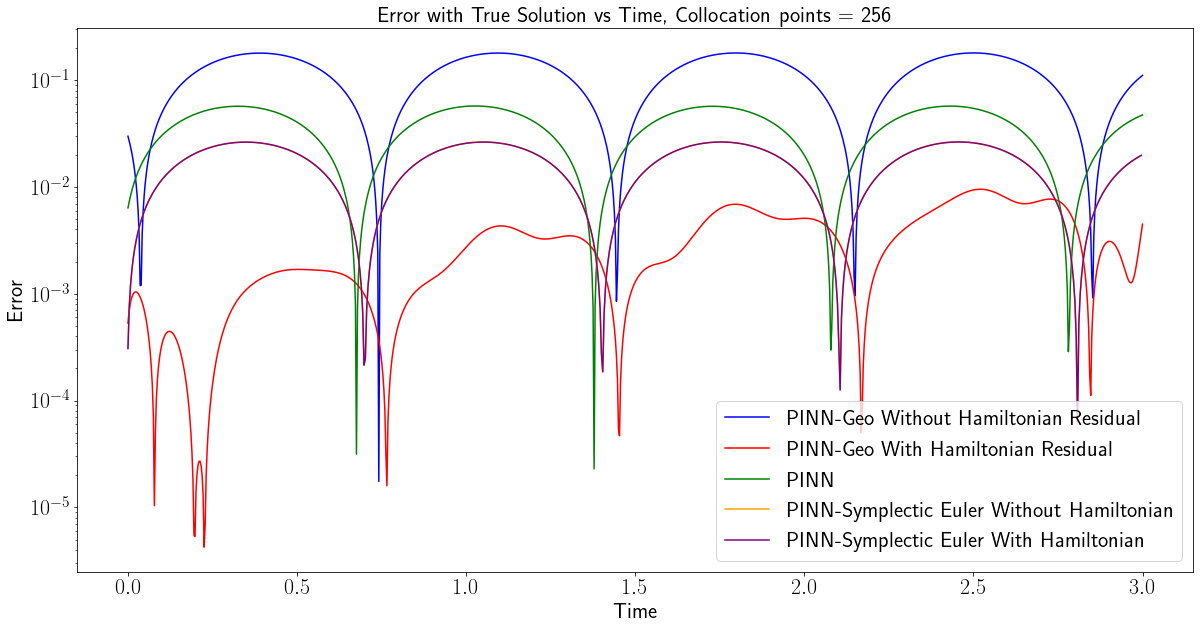

In [37]:
without_hamiltonian_residual=tf.keras.models.load_model(f"model_with_hamiltonian_and_without_residual_collocation_points_{f}",compile=False)
with_hamiltonian_residual = tf.keras.models.load_model(f"model_with_hamiltonian_and_residual_collocation_points_{f}",compile=False)
base_pinn = tf.keras.models.load_model(f"model_without_hamiltonian_and_without_residual_collocation_points_{f}",compile=False)
pinn_symplectic_euler_without_hamiltonian = tf.keras.models.load_model(f"model_without_hamiltonian_collocation_points_{f}",compile=False)   
pinn_symplectic_euler_with_hamiltonian = tf.keras.models.load_model(f"model_with_hamiltonian_collocation_points_{f}",compile=False) 
true_solution = oscillator(x0,x_0,t,k,m)
qq,pp,tt = make_predictions(pinn_symplectic_euler_without_hamiltonian,l,u,x0,x_0,1/(f-1))
plt.figure(figsize=figsize)
# plt.plot(t,true_solution,color="red",label="True Solution")
plt.semilogy(t,tf.abs(model_prediction(without_hamiltonian_residual,inp)-true_solution),color="blue",label="PINN-Geo Without Hamiltonian Residual")
plt.semilogy(t,tf.abs(true_solution-model_prediction(with_hamiltonian_residual,inp)),color="red",label="PINN-Geo With Hamiltonian Residual")
plt.semilogy(t,tf.abs(true_solution-model_prediction(base_pinn,inp)),color="green",label="PINN")
qq,pp,tt = make_predictions(pinn_symplectic_euler_without_hamiltonian,l,u,x0,x_0,1/(f-1))
plt.semilogy(tt,tf.abs(oscillator(x0,x_0,tt,k,m)-qq),color="orange",label="PINN-Symplectic Euler Without Hamiltonian")
qq,pp,tt = make_predictions(pinn_symplectic_euler_with_hamiltonian,l,u,x0,x_0,1/(f-1))
plt.semilogy(tt,tf.abs(oscillator(x0,x_0,tt,k,m)-qq),color="purple",label="PINN-Symplectic Euler With Hamiltonian")
plt.xlabel("Time",fontsize=fontsize)
plt.ylabel("Error",fontsize=fontsize)
plt.title(f"Error with True Solution vs Time, Collocation points = {f}",fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: myPINN is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


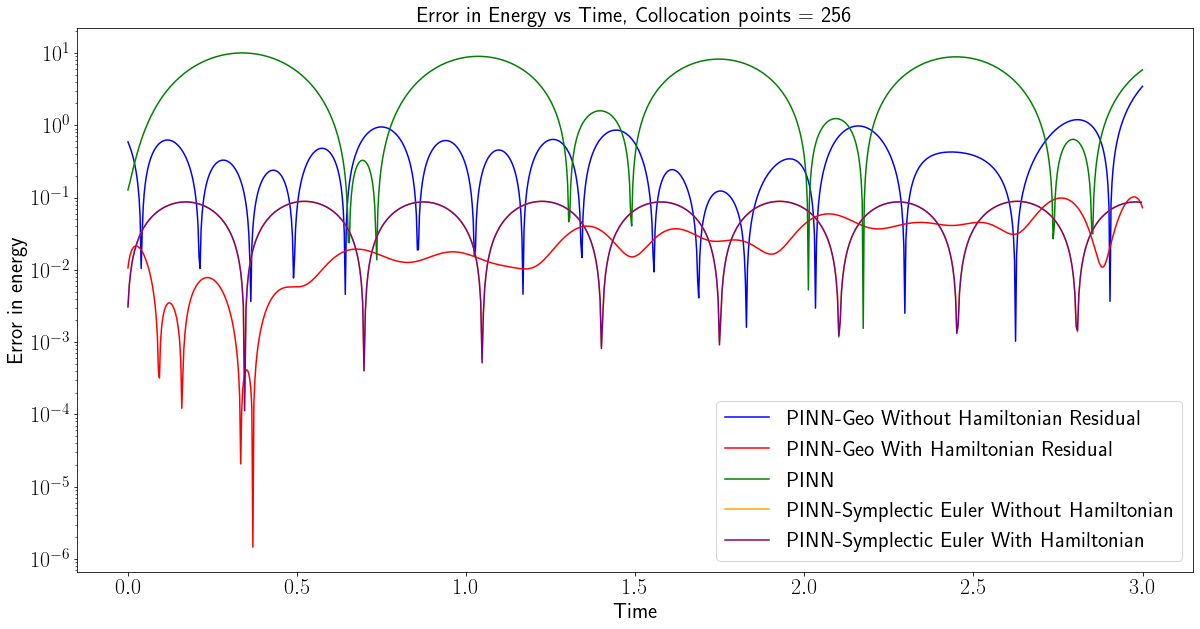

In [38]:
without_hamiltonian_residual=tf.keras.models.load_model(f"model_with_hamiltonian_and_without_residual_collocation_points_{f}",compile=False)
with_hamiltonian_residual = tf.keras.models.load_model(f"model_with_hamiltonian_and_residual_collocation_points_{f}",compile=False)
base_pinn = tf.keras.models.load_model(f"model_without_hamiltonian_and_without_residual_collocation_points_{f}",compile=False)
pinn_symplectic_euler_without_hamiltonian = tf.keras.models.load_model(f"model_without_hamiltonian_collocation_points_{f}",compile=False)   
pinn_symplectic_euler_with_hamiltonian = tf.keras.models.load_model(f"model_with_hamiltonian_collocation_points_{f}",compile=False) 
true_energy = m*x_0**2/2 + k*x0**2/2
qq,pp,tt = make_predictions(pinn_symplectic_euler_without_hamiltonian,l,u,x0,x_0,1/(f-1))
plt.figure(figsize=figsize)
# plt.plot(t,true_energy,color="red",label="True Solution")
plt.semilogy(t,tf.abs(energy_prediction(without_hamiltonian_residual,inp)-true_energy),color="blue",label="PINN-Geo Without Hamiltonian Residual")
plt.semilogy(t,tf.abs(true_energy-energy_prediction(with_hamiltonian_residual,inp)),color="red",label="PINN-Geo With Hamiltonian Residual")
plt.semilogy(t,tf.abs(true_energy-energy_prediction(base_pinn,inp)),color="green",label="PINN")
qq,pp,tt = make_predictions(pinn_symplectic_euler_without_hamiltonian,l,u,x0,x_0,1/(f-1))
plt.semilogy(tt,tf.abs(true_energy - (pp**2/(2*m) + (1/2) * k* qq**2)) ,color="orange",label="PINN-Symplectic Euler Without Hamiltonian")
qq,pp,tt = make_predictions(pinn_symplectic_euler_with_hamiltonian,l,u,x0,x_0,1/(f-1))
plt.semilogy(tt,tf.abs(true_energy-(pp**2/(2*m) + k*qq**2/2)),color="purple",label="PINN-Symplectic Euler With Hamiltonian")
plt.xlabel("Time",fontsize=fontsize)
plt.ylabel("Error in energy",fontsize=fontsize)
plt.title(f"Error in Energy vs Time, Collocation points = {f}",fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [39]:
error_without_hamiltonian_inf_norm=[]
error_with_hamiltonian_inf_norm=[]
error_base_pinn_inf_norm=[]
error_pinn_symplectic_euler_without_hamiltonian_inf_norm=[]
error_pinn_symplectic_euler_with_hamiltonian_inf_norm=[]
ns = np.array([2**i for i in range(3,9)],dtype=np.float64)
for i in range(3,9):
    f = 2**i
    without_hamiltonian_residual=tf.keras.models.load_model(f"model_with_hamiltonian_and_without_residual_collocation_points_{f}",compile=False)
    with_hamiltonian_residual = tf.keras.models.load_model(f"model_with_hamiltonian_and_residual_collocation_points_{f}",compile=False)
    base_pinn = tf.keras.models.load_model(f"model_without_hamiltonian_and_without_residual_collocation_points_{f}",compile=False)
    pinn_symplectic_euler_without_hamiltonian = tf.keras.models.load_model(f"model_without_hamiltonian_collocation_points_{f}",compile=False)
    pinn_symplectic_euler_with_hamiltonian = tf.keras.models.load_model(f"model_with_hamiltonian_collocation_points_{f}",compile=False)
    qq,pp,tt = make_predictions(pinn_symplectic_euler_without_hamiltonian,l,u,x0,x_0,1/(f-1))
    error_pinn_symplectic_euler_without_hamiltonian_inf_norm.append(tf.reduce_max(tf.abs(oscillator(x0,x_0,tt,k,m)-qq)))
    qq,pp,tt = make_predictions(pinn_symplectic_euler_with_hamiltonian,l,u,x0,x_0,1/(f-1))
    error_pinn_symplectic_euler_with_hamiltonian_inf_norm.append(tf.reduce_max(tf.abs(oscillator(x0,x_0,tt,k,m)-qq)))
    error_without_hamiltonian_inf_norm.append( tf.reduce_max(tf.abs(model_prediction(without_hamiltonian_residual,inp)-true_solution)))
    error_with_hamiltonian_inf_norm.append(tf.reduce_max(tf.abs(model_prediction(with_hamiltonian_residual,inp)-true_solution)))
    error_base_pinn_inf_norm.append(tf.reduce_max(tf.abs(model_prediction(base_pinn,inp)-true_solution)))
a1,b1= np.polyfit(np.log2(ns),np.log2([x.numpy() for x in error_with_hamiltonian_inf_norm]),1)
a2,b2 = np.polyfit(np.log2(ns),np.log2([x.numpy() for x in error_without_hamiltonian_inf_norm]),1)
a3,b3 = np.polyfit(np.log2(ns),np.log2([x.numpy() for x in error_base_pinn_inf_norm]),1)
a4,b4 = np.polyfit(np.log2(ns),np.log2([x.numpy() for x in error_pinn_symplectic_euler_without_hamiltonian_inf_norm]),1)
a5,b5 = np.polyfit(np.log2(ns),np.log2([x.numpy() for x in error_pinn_symplectic_euler_with_hamiltonian_inf_norm]),1)

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: myPINN is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


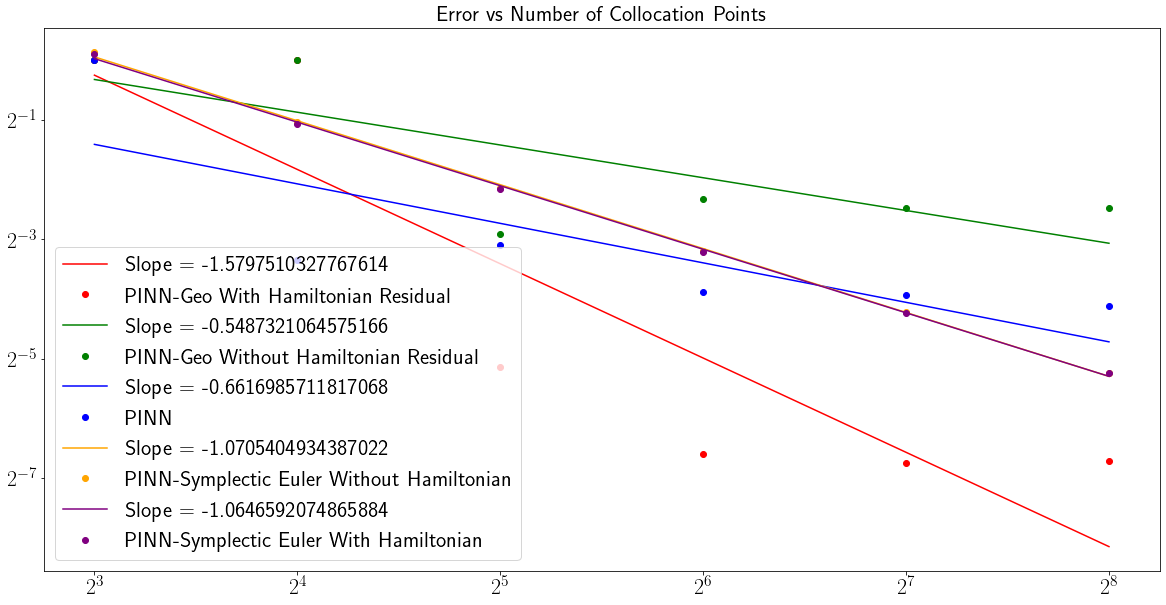

In [40]:
plt.figure(figsize=figsize)
plt.loglog(ns,2**(a1*np.log2(ns)+b1),color="red",label=f"Slope = {str(a1)}",base=2)
plt.loglog(ns,error_with_hamiltonian_inf_norm,base=2,marker='o',linewidth=0.0,color='red',label="PINN-Geo With Hamiltonian Residual")
plt.loglog(ns,2**(a2*np.log2(ns)+b2),color="green",label=f"Slope = {str(a2)}",base=2)
plt.loglog(ns,error_without_hamiltonian_inf_norm,base=2,marker='o',linewidth=0.0,color='green',label="PINN-Geo Without Hamiltonian Residual")
plt.loglog(ns,2**(a3*np.log2(ns)+b3),color="blue",label=f"Slope = {str(a3)}",base=2)
plt.loglog(ns,error_base_pinn_inf_norm,base=2,marker='o',linewidth=0.0,color='blue',label="PINN")
plt.loglog(ns,2**(a4*np.log2(ns)+b4),color="orange",label=f"Slope = {str(a4)}",base=2)
plt.loglog(ns,error_pinn_symplectic_euler_without_hamiltonian_inf_norm,base=2,marker='o',linewidth=0.0,color='orange',label="PINN-Symplectic Euler Without Hamiltonian")
plt.loglog(ns,2**(a5*np.log2(ns)+b5),color="purple",label=f"Slope = {str(a5)}",base=2)
plt.loglog(ns,error_pinn_symplectic_euler_with_hamiltonian_inf_norm,base=2,marker='o',linewidth=0.0,color='purple',label="PINN-Symplectic Euler With Hamiltonian")
plt.title("Error vs Number of Collocation Points",fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Number of Collocation Points",fontsize=fontsize)
plt.ylabel("Error",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

### **Inf Norm Error**

### **ReLU** : 1.000268383175795

### **Tanh** : 0.17802936150315768

### **SIREN** : 0.13124376605774926

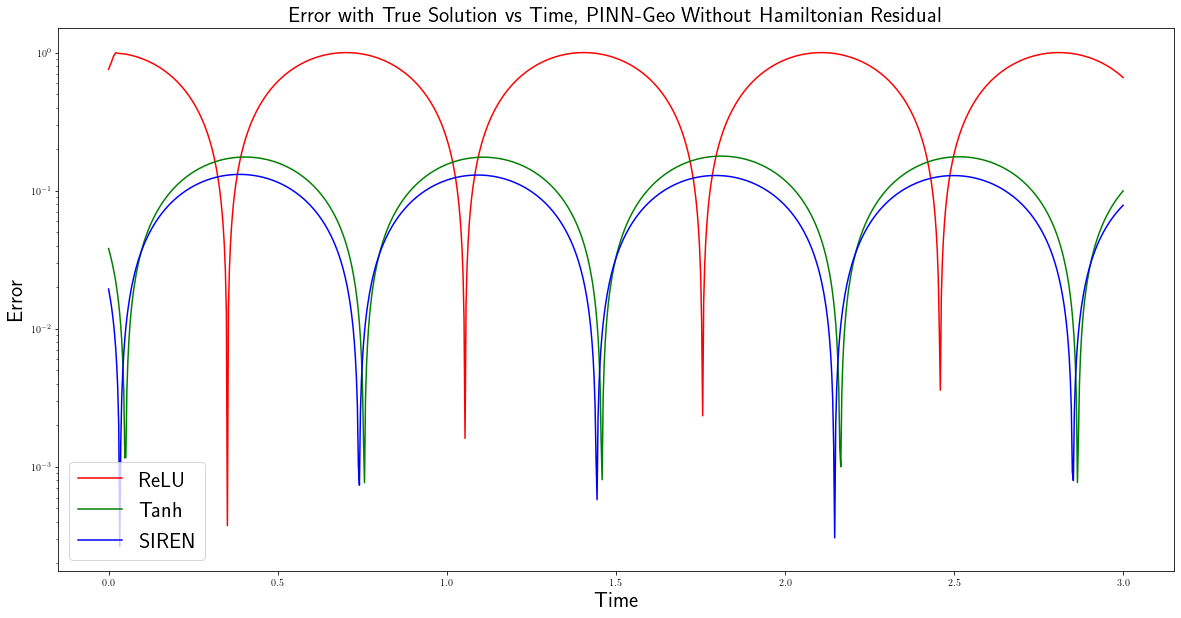

In [48]:
activation_functions = ['tanh','relu','sin']
without_hamiltonian_residual_relu=tf.keras.models.load_model(f"model_with_hamiltonian_and_without_residual_activation_relu",compile=False)
without_hamiltonian_residual_tanh=tf.keras.models.load_model(f"model_with_hamiltonian_and_without_residual_activation_tanh",compile=False)
without_hamiltonian_residual_sin=tf.keras.models.load_model(f"model_with_hamiltonian_and_without_residual_activation_sin",compile=False)
plt.figure(figsize=figsize) 
plt.semilogy(t,tf.abs(true_solution-model_prediction(without_hamiltonian_residual_relu,inp)),color="red",label="ReLU")
plt.semilogy(t,tf.abs(true_solution-model_prediction(without_hamiltonian_residual_tanh,inp)),color="green",label="Tanh")
plt.semilogy(t,tf.abs(true_solution-model_prediction(without_hamiltonian_residual_sin,inp)),color="blue",label="SIREN") 
plt.xlabel("Time",fontsize=fontsize)
plt.ylabel("Error",fontsize=fontsize)   
plt.title("Error with True Solution vs Time, PINN-Geo Without Hamiltonian Residual",fontsize=fontsize)
plt.legend(fontsize=fontsize)
display(Markdown(f'### **Inf Norm Error**'))
display(Markdown(f"### **ReLU** : {tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual_relu,inp))).numpy()}"))
display(Markdown(f"### **Tanh** : {tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual_tanh,inp))).numpy()}"))
display(Markdown(f"### **SIREN** : {tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual_sin,inp))).numpy()}"))
plt.show()

### **Inf Norm Error**

### **ReLU** : 1.000268383175795

### **Tanh** : 0.17802936150315768

### **SIREN** : 0.13124376605774926

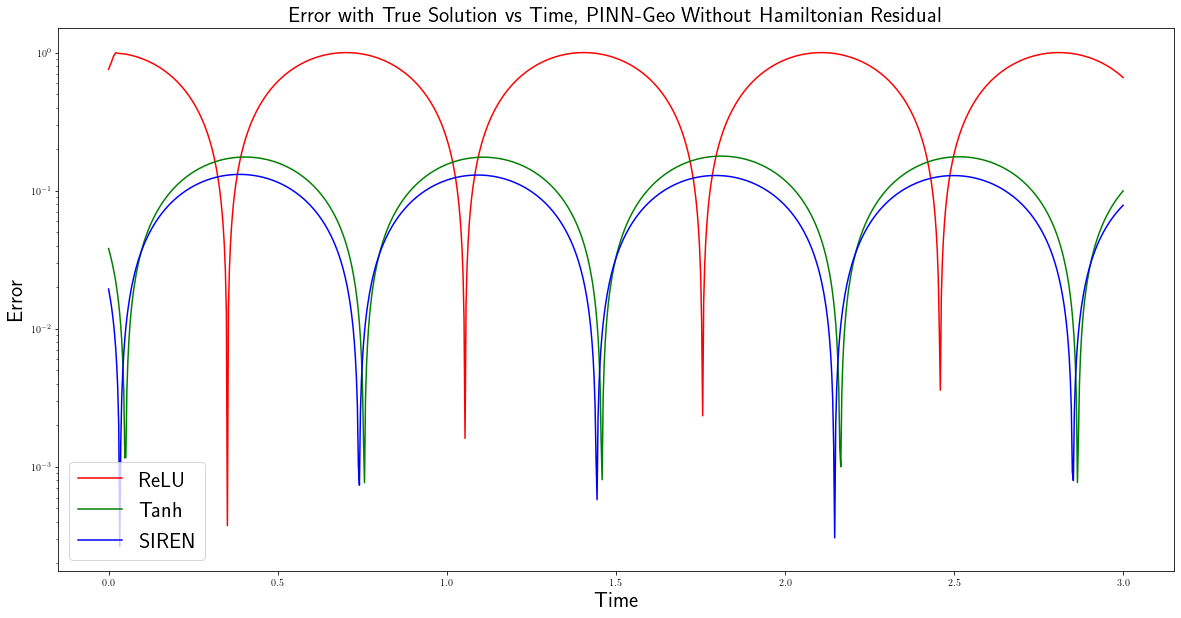

In [47]:
activation_functions = ['tanh','relu','sin']
with_hamiltonian_residual_relu=tf.keras.models.load_model(f"model_with_hamiltonian_with_residual_activation_relu",compile=False)
with_hamiltonian_residual_tanh=tf.keras.models.load_model(f"model_with_hamiltonian_with_residual_activation_tanh",compile=False)
with_hamiltonian_residual_sin=tf.keras.models.load_model(f"model_with_hamiltonian_with_residual_activation_sin",compile=False)
plt.figure(figsize=figsize) 
plt.semilogy(t,tf.abs(true_solution-model_prediction(without_hamiltonian_residual_relu,inp)),color="red",label="ReLU")
plt.semilogy(t,tf.abs(true_solution-model_prediction(without_hamiltonian_residual_tanh,inp)),color="green",label="Tanh")
plt.semilogy(t,tf.abs(true_solution-model_prediction(without_hamiltonian_residual_sin,inp)),color="blue",label="SIREN")    
plt.xlabel("Time",fontsize=fontsize)
plt.ylabel("Error",fontsize=fontsize)
plt.title("Error with True Solution vs Time, PINN-Geo Without Hamiltonian Residual",fontsize=fontsize)
plt.legend(fontsize=fontsize)
display(Markdown(f'### **Inf Norm Error**'))
display(Markdown(f"### **ReLU** : {tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual_relu,inp))).numpy()}"))
display(Markdown(f"### **Tanh** : {tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual_tanh,inp))).numpy()}"))
display(Markdown(f"### **SIREN** : {tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual_sin,inp))).numpy()}"))
plt.show()

In [43]:
error_with_hamiltonian_inf_norm = []
error_without_hamiltonian_inf_norm = [] 
ns = [2**i for i in range(3,8)]
for i in range(3,8):
    batch_size = 2**i
    with_hamiltonian_residual = tf.keras.models.load_model(f"model_with_hamiltonian_batch_size_{batch_size}",compile=False)
    without_hamiltonian_residual = tf.keras.models.load_model(f"model_with_hamiltonian_and_without_batch_size_{batch_size}",compile=False)
    error_with_hamiltonian_inf_norm.append(tf.reduce_max(tf.abs(true_solution-model_prediction(with_hamiltonian_residual,inp))).numpy())
    error_without_hamiltonian_inf_norm.append(tf.reduce_max(tf.abs(true_solution-model_prediction(without_hamiltonian_residual,inp))).numpy())
a1,b1 = np.polyfit(np.log2(ns),np.log2(error_with_hamiltonian_inf_norm),1)
a2,b2 = np.polyfit(np.log2(ns),np.log2(error_without_hamiltonian_inf_norm),1)
    

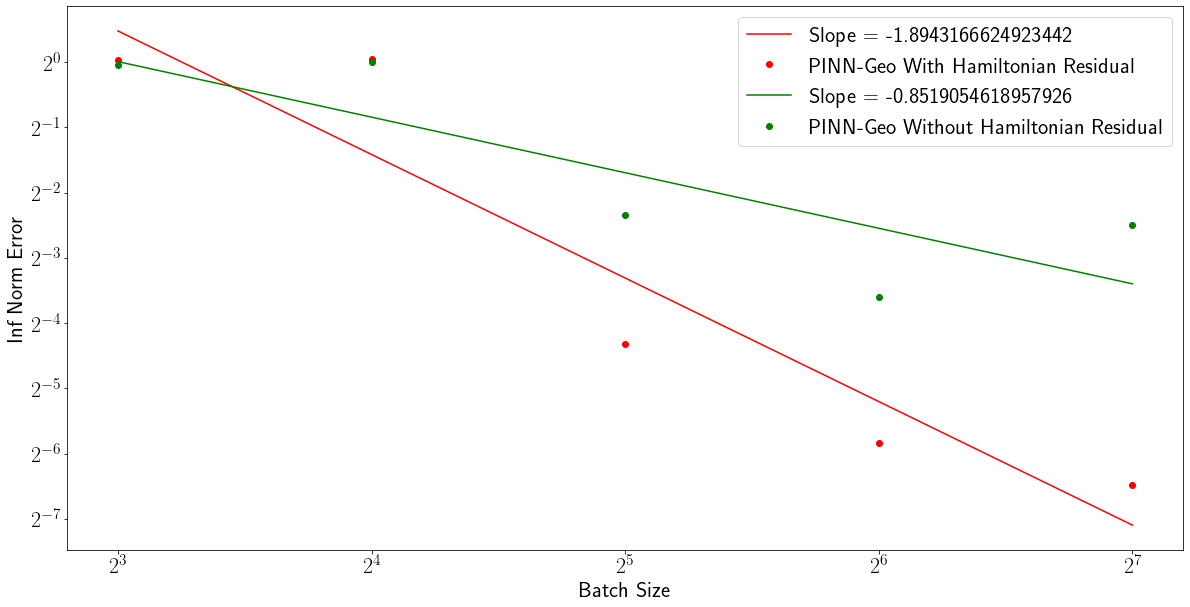

In [44]:
plt.figure(figsize=figsize)
plt.loglog(ns,2**(a1*np.log2(ns)+b1),color="red",label=f"Slope = {str(a1)}",base=2)
plt.loglog(ns,error_with_hamiltonian_inf_norm,base=2,marker='o',linewidth=0.0,color='red',label="PINN-Geo With Hamiltonian Residual")
plt.loglog(ns,2**(a2*np.log2(ns)+b2),color="green",label=f"Slope = {str(a2)}",base=2)
plt.loglog(ns,error_without_hamiltonian_inf_norm,base=2,marker='o',linewidth=0.0,color='green',label="PINN-Geo Without Hamiltonian Residual")
plt.xlabel("Batch Size",fontsize=fontsize)
plt.ylabel("Inf Norm Error",fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()